In [19]:
from scipy.integrate import solve_ivp
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

In [20]:
#k1 = 1         k2 = 2          phi_in = 1      phi_out = 2     v = 10          km = 1          klanda = 1      alpha*beta
#constants[0]   constants[1]    constants[2]    constants[3]    constants[4]    constants[5]    constants[6]    constants[7]  

#Valores estimados de las constantes MEAN
#const_mean = [ 0.09350985, 0.58026128, 0.43635995, 0.54207802, -0.45358854, 0.6839959, 0.36064184, 0.65045037]
const_mean = [0.64403665, 2.04953861, 0.30205504, 0.34651345, 1.52979939, 1.71869996, 3.31121888, 1.10105449]
k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
print(k1)

0.64403665


With these values for the constants on the model we redo the previous procedure to compute A and P for different values of $n$ and $A_{out}$

In [21]:
def model1(t, variables, n, k1, k2, phi_in, phi_out, A_out, v, km, klanda, landa0):
    P, A = variables
    alpha = landa0/(1+klanda*A) #A initial o A a lo largo del tiempo(FUERA O DENTRO)
    dPdt = alpha*n*(1+k2)/((1+k1*A)**2*(1+k2*P)) - alpha*P
    dAdt = phi_in*A_out - phi_out*A - v*P*A/(km+P) - alpha*A
    return [dPdt, dAdt]


def model2(t, variables, n, k1, k2, phi_in, phi_out, A_out, v, km, klanda, landa0, alphaBeta):
    P, A = variables
    landa = landa0/(1+klanda*A) #A initial o A a lo largo del tiempo(FUERA O DENTRO)
    dPdt = alphaBeta*n/((1+k1*A)**2*(1+k2*P)) - landa*P
    dAdt = phi_in*A_out - phi_out*A - v*P*A/(km+P) - landa*A
    return [dPdt, dAdt]




In [22]:
def computeAPnaout(model,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist):
    k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
    t_span = [0, tf]
    
    #P_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n
    #A_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n

    P_n_aout = []
    A_n_aout = []

    for i in range(0,len(Aout_values)):
        Pcurrent = []
        Acurrent = []
        for j in range(0,len(n_values)):
            sol = solve_ivp(model2, t_span, initial_conditions, args=(n_values[j],k1,k2, phi_in, phi_out, Aout_values[i], v, km, klanda, landa0, alphaBeta), t_eval=np.linspace(0, tf, equidist))
            #print(i,j)
            Pcurrent.append(sol.y[0])
            Acurrent.append(sol.y[1])
        P_n_aout.append(Pcurrent)
        A_n_aout.append(Acurrent)
    return(P_n_aout,A_n_aout)


def computeAPnaout_equilibrium(model,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist):
    k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
    t_span = [0, tf]
    
    P_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n
    A_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n

    for i in range(0,len(Aout_values)):
        for j in range(0,len(n_values)):
            sol = solve_ivp(model2, t_span, initial_conditions, args=(n_values[j],k1,k2, phi_in, phi_out, Aout_values[i], v, km, klanda, landa0, alphaBeta), t_eval=np.linspace(0, tf, equidist))
            #print(i,j)
            P_n_aout[i,j] = sol.y[0][-1]
            A_n_aout[i,j] = sol.y[1][-1]
    return(P_n_aout,A_n_aout)



In [23]:
def Gfunction(A,landa0,klanda):
    return landa0/(1+klanda*A)

$$
    \frac{d}{dt}  B_1 =G(A_1,1)B_1-\delta\Big(B_1-2(1+\Delta)B_2 \Big),
$$
    
$$
    \frac{d}{dt}  B_n =G(A_n, n)B_n-\delta\Big(n(2+\Delta)B_n-(n-1)B_{n-1}-(n+1)(1+\Delta)B_{n+1} \Big),     (n=2, \dots, N-1)
$$
$$
    \frac{d}{dt}  B_N =G(A_N,N)B_N-\delta
    \Big(N(1+\Delta)B_N-(N-1)B_{N-1} \Big).
$$
The growth function $$G(A,n)=\frac{\lambda_0}{(1+k_\lambda
  A)}$$
  is decreased by the
internal antibiotic concentration. 

Where used constants are: $\delta=1e-2, \Delta=6.4$ and $k_c=0$

In [24]:
def model_Bn1(t, variables, klanda,landa0,A_n_aout,deltaMin,deltaMay,Aout,equidist,tf):
    B1,B2,B3,B4,B5,B6,B7,B8,B9,B10 = variables

    dB1dt = Gfunction(A_n_aout[Aout][0],landa0,klanda)*B1 - deltaMin*(B1-2*(1+deltaMay)*B2)
    dB2dt = Gfunction(A_n_aout[Aout][1],landa0,klanda)*B2 - deltaMin*(2*(2+deltaMay)*B2 - (1)*B1 - (3)*(1 + deltaMay)*B3 )
    dB3dt = Gfunction(A_n_aout[Aout][2],landa0,klanda)*B3 - deltaMin*(3*(2+deltaMay)*B3 - (2)*B2 - (4)*(1 + deltaMay)*B4 )
    dB4dt = Gfunction(A_n_aout[Aout][3],landa0,klanda)*B4 - deltaMin*(4*(2+deltaMay)*B4 - (3)*B3 - (5)*(1 + deltaMay)*B5 )
    dB5dt = Gfunction(A_n_aout[Aout][4],landa0,klanda)*B5 - deltaMin*(5*(2+deltaMay)*B5 - (4)*B4 - (6)*(1 + deltaMay)*B6 )
    dB6dt = Gfunction(A_n_aout[Aout][5],landa0,klanda)*B6 - deltaMin*(6*(2+deltaMay)*B6 - (5)*B5 - (7)*(1 + deltaMay)*B7 )
    dB7dt = Gfunction(A_n_aout[Aout][6],landa0,klanda)*B7 - deltaMin*(7*(2+deltaMay)*B7 - (6)*B6 - (8)*(1 + deltaMay)*B8 )
    dB8dt = Gfunction(A_n_aout[Aout][7],landa0,klanda)*B8 - deltaMin*(8*(2+deltaMay)*B8 - (7)*B7 - (9)*(1 + deltaMay)*B9 )
    dB9dt = Gfunction(A_n_aout[Aout][8],landa0,klanda)*B9 - deltaMin*(9*(2+deltaMay)*B9 - (8)*B8 - (10)*(1 + deltaMay)*B10 )
    dB10dt = Gfunction(A_n_aout[Aout][9],landa0,klanda)*B10 - deltaMin*(10*(1+deltaMay)*B10 - 9*B9)

    return [dB1dt,dB2dt,dB3dt,dB4dt,dB5dt,dB6dt,dB7dt,dB8dt,dB9dt,dB10dt]



def model_Bn2(t, variables, klanda,landa0,A_n_aout,deltaMin,deltaMay,Aout,equidist,tf):
    B1,B2,B3,B4,B5,B6,B7,B8,B9,B10 = variables
    #print(t)

    tt = int(t)
    if tt >= len(A_n_aout[Aout][0]):
        tt = -1

    #print(tt)

    dB1dt = Gfunction(A_n_aout[Aout][0][tt],landa0,klanda)*B1 - deltaMin*(B1-2*(1+deltaMay)*B2)
    dB2dt = Gfunction(A_n_aout[Aout][1][tt],landa0,klanda)*B2 - deltaMin*(2*(2+deltaMay)*B2 - (1)*B1 - (3)*(1 + deltaMay)*B3 )
    dB3dt = Gfunction(A_n_aout[Aout][2][tt],landa0,klanda)*B3 - deltaMin*(3*(2+deltaMay)*B3 - (2)*B2 - (4)*(1 + deltaMay)*B4 )
    dB4dt = Gfunction(A_n_aout[Aout][3][tt],landa0,klanda)*B4 - deltaMin*(4*(2+deltaMay)*B4 - (3)*B3 - (5)*(1 + deltaMay)*B5 )
    dB5dt = Gfunction(A_n_aout[Aout][4][tt],landa0,klanda)*B5 - deltaMin*(5*(2+deltaMay)*B5 - (4)*B4 - (6)*(1 + deltaMay)*B6 )
    dB6dt = Gfunction(A_n_aout[Aout][5][tt],landa0,klanda)*B6 - deltaMin*(6*(2+deltaMay)*B6 - (5)*B5 - (7)*(1 + deltaMay)*B7 )
    dB7dt = Gfunction(A_n_aout[Aout][6][tt],landa0,klanda)*B7 - deltaMin*(7*(2+deltaMay)*B7 - (6)*B6 - (8)*(1 + deltaMay)*B8 )
    dB8dt = Gfunction(A_n_aout[Aout][7][tt],landa0,klanda)*B8 - deltaMin*(8*(2+deltaMay)*B8 - (7)*B7 - (9)*(1 + deltaMay)*B9 )
    dB9dt = Gfunction(A_n_aout[Aout][8][tt],landa0,klanda)*B9 - deltaMin*(9*(2+deltaMay)*B9 - (8)*B8 - (10)*(1 + deltaMay)*B10 )
    dB10dt = Gfunction(A_n_aout[Aout][9][tt],landa0,klanda)*B10 - deltaMin*(10*(1+deltaMay)*B10 - 9*B9)

    return [dB1dt,dB2dt,dB3dt,dB4dt,dB5dt,dB6dt,dB7dt,dB8dt,dB9dt,dB10dt]


def model_Bn3(t, variables, klanda,landa0,A_n_aout,deltaMin,deltaMay,Aout,equidist,tf):
    B1,B2,B3,B4,B5,B6,B7,B8,B9,B10 = variables
    #print(t)

    tt = int(t)
    if tt >= len(A_n_aout[Aout][0]):
        tt = -1

    #print(tt)

    dB1dt = Gfunction(A_n_aout[Aout][0][tt],landa0,klanda)*B1 - deltaMin*((2+deltaMay)*B1-2*(1+deltaMay)*B2)
    dB2dt = Gfunction(A_n_aout[Aout][1][tt],landa0,klanda)*B2 - deltaMin*(2*(2+deltaMay)*B2 - (1)*B1 - (3)*(1 + deltaMay)*B3 )
    dB3dt = Gfunction(A_n_aout[Aout][2][tt],landa0,klanda)*B3 - deltaMin*(3*(2+deltaMay)*B3 - (2)*B2 - (4)*(1 + deltaMay)*B4 )
    dB4dt = Gfunction(A_n_aout[Aout][3][tt],landa0,klanda)*B4 - deltaMin*(4*(2+deltaMay)*B4 - (3)*B3 - (5)*(1 + deltaMay)*B5 )
    dB5dt = Gfunction(A_n_aout[Aout][4][tt],landa0,klanda)*B5 - deltaMin*(5*(2+deltaMay)*B5 - (4)*B4 - (6)*(1 + deltaMay)*B6 )
    dB6dt = Gfunction(A_n_aout[Aout][5][tt],landa0,klanda)*B6 - deltaMin*(6*(2+deltaMay)*B6 - (5)*B5 - (7)*(1 + deltaMay)*B7 )
    dB7dt = Gfunction(A_n_aout[Aout][6][tt],landa0,klanda)*B7 - deltaMin*(7*(2+deltaMay)*B7 - (6)*B6 - (8)*(1 + deltaMay)*B8 )
    dB8dt = Gfunction(A_n_aout[Aout][7][tt],landa0,klanda)*B8 - deltaMin*(8*(2+deltaMay)*B8 - (7)*B7 - (9)*(1 + deltaMay)*B9 )
    dB9dt = Gfunction(A_n_aout[Aout][8][tt],landa0,klanda)*B9 - deltaMin*(9*(2+deltaMay)*B9 - (8)*B8 - (10)*(1 + deltaMay)*B10 )
    dB10dt = Gfunction(A_n_aout[Aout][9][tt],landa0,klanda)*B10 - deltaMin*(10*(2+deltaMay)*B10 - 9*B9)

    return [dB1dt,dB2dt,dB3dt,dB4dt,dB5dt,dB6dt,dB7dt,dB8dt,dB9dt,dB10dt]

In [25]:
def computeModelBN(tf,A_n_aout,Aout_values,const_mean,initial_conditions,equidist):
    #Constants
    k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
    deltaMin = 10**(-3)
    deltaMay = 6.4
    kc = 0
    landa0 = 0.43
    t_span = [0, tf]
    model_solution = []
    for i in range(0,len(Aout_values)):
        #print(i)
        sol = solve_ivp(model_Bn2,t_span,initial_conditions,args=(klanda,landa0,A_n_aout,deltaMin,deltaMay,i,equidist,tf),t_eval=np.linspace(0, tf, equidist))
        model_solution.append([sol.y[0],sol.y[1],sol.y[2],sol.y[3],sol.y[4],sol.y[5],sol.y[6],sol.y[7],sol.y[8],sol.y[9]])
    return(model_solution)


In [26]:
def computePromP(P_n_aout,Aout_values,n_values,model_solution,time):
    promP = np.zeros(len(Aout_values)) #x=Aout//y = n
    for i in range(0,len(Aout_values)):
        num = 0; den = 0
        for j in range(0,len(n_values)):
            num = num + P_n_aout[i][j][time]*model_solution[i][j][time]
            den = den + model_solution[i][j][time]
        promP[i] = num/den
    return(promP)


In [30]:
initial_conditions = [1.2, 0]  
n_values = np.linspace(1, 10, 10)
Aout_values = np.linspace(0, 50, 11)
landa0 = 0.43
tf = 100
equidist = 1000
P,A = computeAPnaout(model2,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist)

print(len(A))
print(len(A[0][0]))
print(A[0][0])

11
1000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [28]:
initial_conditionsbn = [1] * 10
model234 = computeModelBN(tf,A,Aout_values,const_mean,initial_conditionsbn,equidist)
print(len(model234))
print(len(model234[0]))
print(len(model234[0][0]))

11
10
1000


In [47]:
final_prom = []
print(len(final_prom))

P_n_aout = []
A_n_aout = []
initial_conditions = [1, 0] 
tf = 100
equidist = 100
landa0 = 0.43

P_n_aout,A_n_aout = computeAPnaout(model2,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist)

model_solution = []
initial_conditionsbn = [1,0,0,0,0,0,0,0,0,0]
model_solution = computeModelBN(tf,A_n_aout,Aout_values,const_mean,initial_conditionsbn,equidist)


0


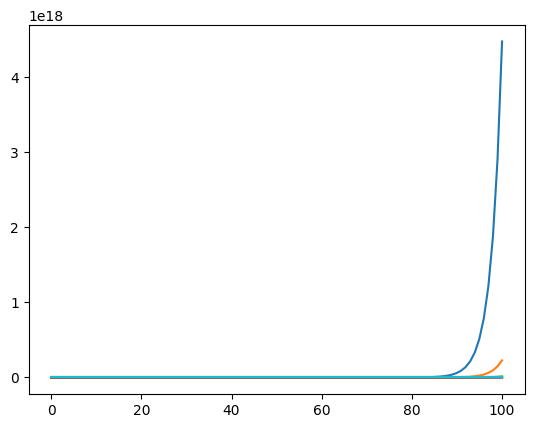

In [48]:
plt.figure()
for n in range (0,len(n_values)):
    a = 0
    plt.plot(np.linspace(0, tf, equidist),model_solution[a][n])

In [49]:
print(Aout_values)

[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]


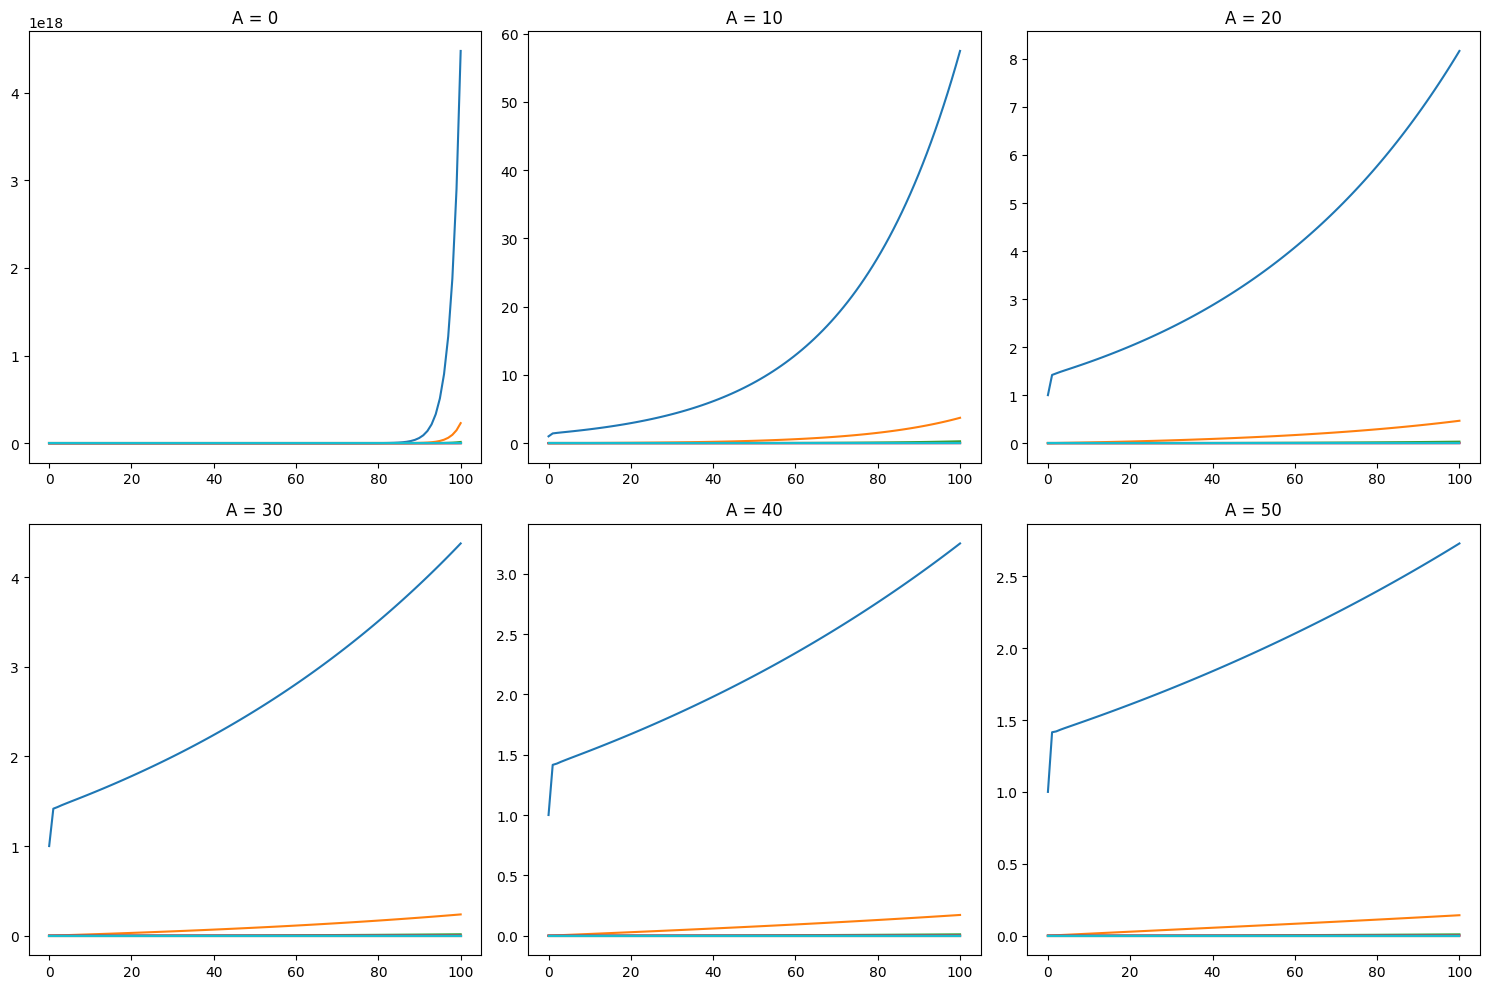

In [50]:
# Crear una figura y conjunto de subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

i = 0
for a in range (0,6,2):
    
    for n in range (0,len(n_values)):
        
        axs[0, i].plot(np.linspace(0, tf, equidist),model_solution[a][n])
        title = 'A = ' + str(a*5)
        axs[0, i].set_title(title)
    i = i+1


i = 0
for a in range (6,len(Aout_values),2):
    
    for n in range (0,len(n_values)):
        
        axs[1, i].plot(np.linspace(0, tf, equidist),model_solution[a][n])
        title = 'A = ' + str(a*5)
        axs[1, i].set_title(title)
    i = i+1

plt.tight_layout()
plt.show()


In [51]:
print(P_n_aout[0][0])
print(len(model_solution[0][0]))

[1.         0.94934652 0.92455518 0.91189976 0.9060984  0.90289273
 0.90152694 0.90089336 0.90035797 0.90025778 0.9003357  0.9001152
 0.89994751 0.90003893 0.90028559 0.90026768 0.89959039 0.89909157
 0.89935274 0.90032214 0.90131478 0.90107337 0.90014631 0.89994918
 0.90049256 0.90062768 0.9001552  0.90001583 0.90026668 0.90038118
 0.8999761  0.89972167 0.899939   0.90044925 0.90057406 0.89993661
 0.89954608 0.89989161 0.90066357 0.90076005 0.89977653 0.89926379
 0.89986644 0.90102532 0.90101909 0.89977724 0.89933296 0.90019519
 0.90131482 0.9006898  0.89979208 0.89988455 0.90071247 0.90074307
 0.9000269  0.89984667 0.9003269  0.90067516 0.90010504 0.8996969
 0.89995069 0.90058649 0.90057177 0.89972705 0.89936688 0.89995512
 0.90095004 0.90084834 0.8996128  0.89916436 0.90006775 0.90137643
 0.90093022 0.89975564 0.89965619 0.90063616 0.90110614 0.90023892
 0.89984177 0.90025559 0.9007396  0.90024005 0.89981381 0.89999207
 0.90052524 0.90045573 0.8997714  0.8995414  0.90006729 0.900830

0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1
[0.94959416 1.03071716 1.02402868 1.01672003 1.01150687 1.00788345
 1.00532223 1.00346902 1.00209683 1.00105837 1.00025602]
2
[0.9252664  1.0539962  1.03018421 1.0156533  1.00739315 1.00246239
 0.99937511 0.99736935 0.99603101 0.99512204 0.99449882]
3
[0.91311217 1.06996256 1.03203584 1.01229799 1.00212772 0.99654561
 0.99332992 0.99142349 0.99028319 0.98961108 0.98923477]
4
[0.90780047 1.08269893 1.03270238 1.00848243 0.99673331 0.99066866
 0.98741581 0.98565925 0.98474474 0.98432389 0.98420079]
5
[0.90505873 1.09356668 1.0329851  1.00463388 0.99141112 0.98490354
 0.9816289  0.98002686 0.97933763 0.97916499 0.97929079]
6
[0.90414186 1.10312189 1.03314453 1.00087089 0.98621609 0.97926557
 0.9759594  0.97450109 0.97402741 0.9740946  0.97446221]
7
[0.90393933 1.11159923 1.03329831 0.99724174 0.98116143 0.97375434
 0.97040083 0.96907167 0.96880094 0.96909735 0.96969786]
8
[0.90382309 1.11917999 1.0334575  0.9937581  0.97625549 0.96837132
 0.96494968 

Text(0.5, 1.0, 'Average P as a function of time for different $A_{out}$')

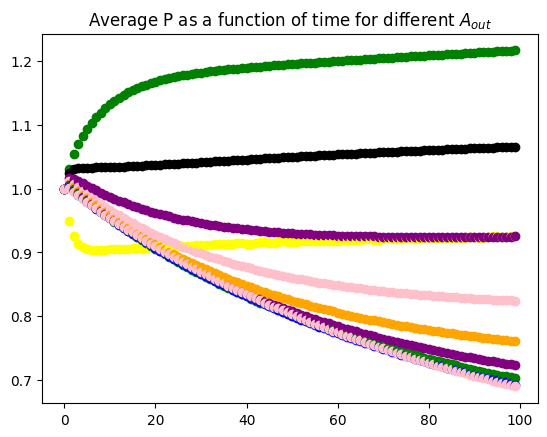

In [52]:
plt.figure()

for time in range (0,equidist):
    print(time)
    promP = []
    promP = computePromP(P_n_aout,Aout_values,n_values,model_solution,time)
    final_prom.append(promP)
    print(promP)

    plt.scatter(time, promP[0], color='yellow')
    plt.scatter(time, promP[1], color='green')
    plt.scatter(time, promP[2], color='black')
    plt.scatter(time, promP[3], color='purple')
    plt.scatter(time, promP[4], color='pink')
    plt.scatter(time, promP[5], color='orange')
    plt.scatter(time, promP[6], color='purple')
    plt.scatter(time, promP[7], color='green')
    plt.scatter(time, promP[8], color='blue')
    plt.scatter(time, promP[9], color='pink')
    
#plt.ylim(0,5)
plt.title('Average P as a function of time for different $A_{out}$')

In [53]:
import pandas as pd

df = pd.read_csv('C:/Users/raque/Documents/UNIVERSIDAD/UC3M/TFM/programación/gfp_data.csv')
Aout_experimental = df['Treatment'];GFP = df['GFP'];Hour_experimental = df['Hour']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


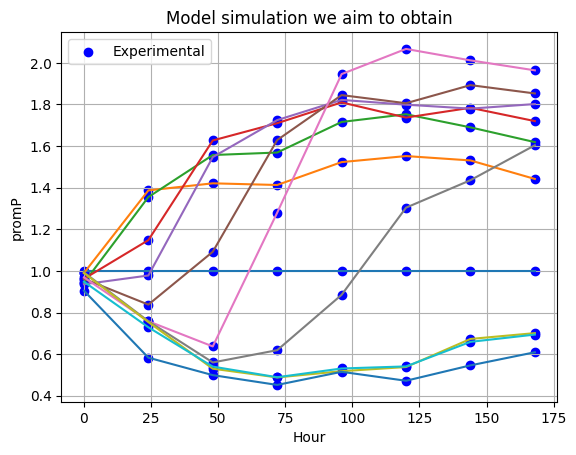

In [55]:
plt.figure()
for i in range (0,11):
    plt.plot(Hour_experimental[(8*i):8*(i+1)],GFP[(8*i):8*(i+1)])
plt.legend()

plt.scatter(Hour_experimental, GFP, color='blue', label='Experimental')

plt.xlabel('Hour')
plt.ylabel('promP')
plt.title('Model simulation we aim to obtain')
plt.grid(True)
plt.legend()